# Spatial Data - Baseline Methods + Cellcharter

In this notebook we will go through two reowned ways of modelling of cellular neighborhoods:

- mean marker representation,
- cell type histogram representation.

In this notebook you will:
- compute appropriate neighborhood-enriched cell representations,
- perform an EDA based on this representations,
- compare them with a [Cellcharter](https://www.nature.com/articles/s41588-023-01588-4) method.

Let's start with installing appropriate package instalation:
- be sure that you are using GPU backend on colab,
- restart session after the installation.

In [ ]:
!pip install squidpy
!pip install cellcharter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Make sure that the following import runs correctly without error (ignore legacy / future warnings):

In [ ]:
import cellcharter

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Once again - set up your data as in previous exercise:

In [ ]:
import anndata
from google.colab import drive
drive.mount('/content/drive')
TRAIN_ANNDATA_PATH = '/content/drive/MyDrive/data/train_adata.h5ad'


train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

The following code setups the data to the [`squidpy`](https://squidpy.readthedocs.io/en/stable/) format:

In [ ]:
import squidpy as sq


train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values
sq.gr.spatial_neighbors(train_anndata, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

The `spatial_neighbors` function from `squidpy` enriched the initial `train_adata` with the information about which cells neighbors each other. Let's inspect the following code:

In [ ]:
train_anndata.obsp['spatial_connectivities'][0].indices

array([ 2,  6,  7, 10, 28, 32, 38], dtype=int32)

it provides you with the indices of the neighbors of `0` cell. Now using this information compute for each cell:

- an average marker expression of all cells in its neighborhood,
- a histogram of counts of each cell type in its neighborhoods. Histogram here means a vector of counts.

Store this information in an array that is ordered the same as `train_anndata.obs` cells.

Prepare an EDA analysis that will:
- run a `PCA` on each representation. `PCA` should explain `90%` of variance,
- similarly to a previous exercise, plot a `sns.clustermap` of the components.

For cell type histogram perform an analysis on both original counts, and [Hellinger](https://en.wikipedia.org/wiki/Hellinger_distance)-transformed ones (Hellinger here means an elementwise square-root transformation).

In [ ]:
import cudf
import cupy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
print(train_anndata.obs['celltypes'])

IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_1    MacCD163
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_3       Mural
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_5          DC
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_7       Tumor
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_8       Tumor
                                                                      ...   
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2713                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2715                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2721                       CD8
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2722                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2725                     Tumor
Name: celltypes, Length: 253433, dtype: category
Categories (14, object): ['B', 'BnT', 'CD4', 'CD8', ..., 'Treg', 'Tumor', 'pDC', 'plasma']


In [ ]:
marker_expressions = train_anndata.layers['exprs']
cell_types = train_anndata.obs['celltypes'].values
if not isinstance(train_anndata.obs['celltypes'], np.dtype):
    train_anndata.obs['celltypes'] = pd.Categorical(train_anndata.obs['celltypes'])
unique_cell_types = train_anndata.obs['celltypes'].cat.categories
num_cell_types = len(unique_cell_types)

# Numpy Arrays to store the results
num_cells = train_anndata.n_obs
num_markers = marker_expressions.shape[1]
avg_marker_expressions = np.zeros((num_cells, num_markers))
cell_type_histograms = np.zeros((num_cells, num_cell_types))

# Compute neighborhood representations.
for i in range(num_cells):
    connectivity = train_anndata.obsp['spatial_connectivities'][i]
    if connectivity is not None:
        neighbor_indices = np.append(connectivity.indices, i)
    else:
        neighbor_indices = np.array([i])

    neighbor_marker_expr = marker_expressions[neighbor_indices]
    avg_marker_expressions[i] = neighbor_marker_expr.mean(axis=0)

    neighbor_cell_types = cell_types[neighbor_indices]
    uniq, counts = np.unique(neighbor_cell_types, return_counts=True)
    cols = np.searchsorted(unique_cell_types, uniq)
    cell_type_histograms[i, cols] = counts

In [ ]:
!pip install fastcluster
import fastcluster

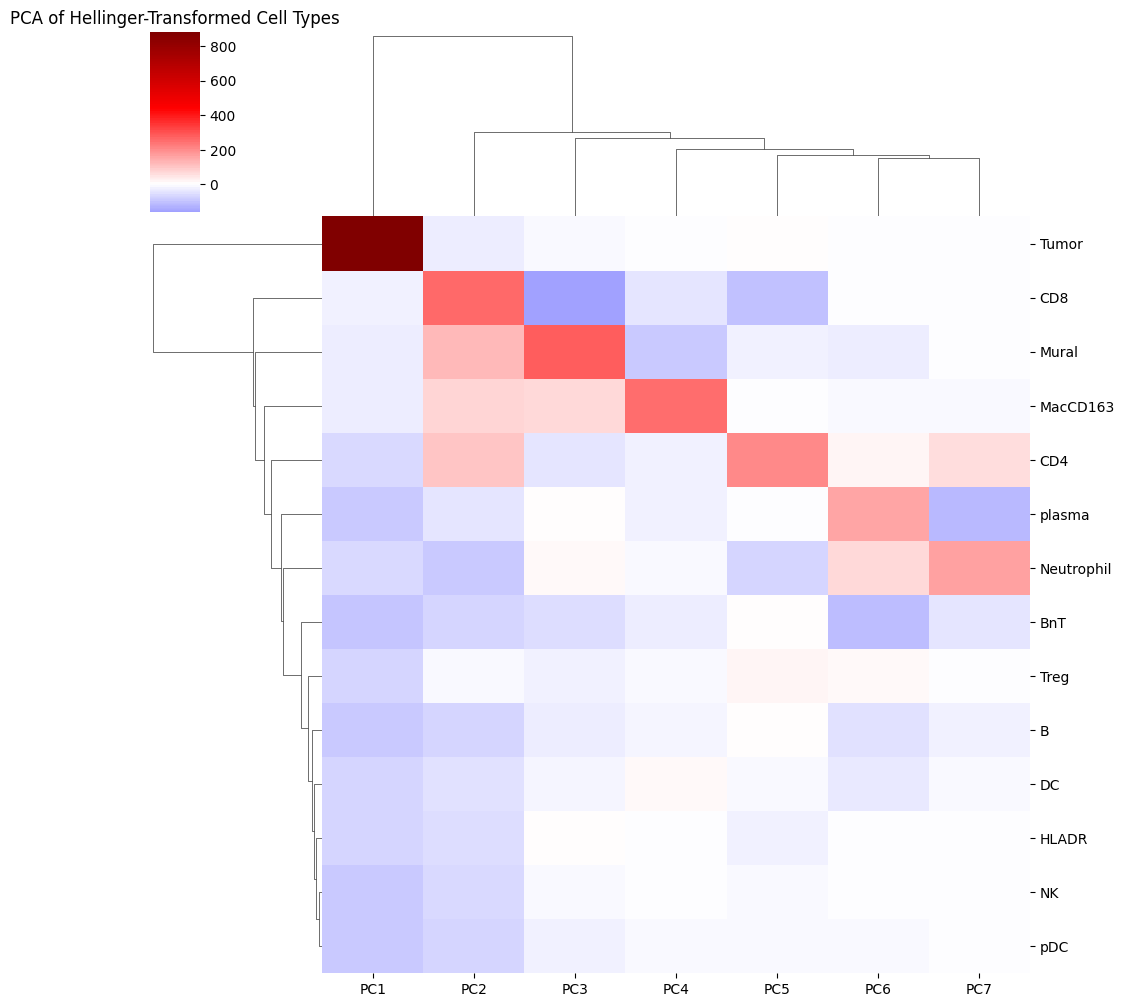

In [ ]:
def run_pca(X, variance_threshold=0.9):
    pca_full = PCA()
    pca_full.fit(X)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def plot_clustermap(data, title):
    sns.clustermap(data, metric='euclidean', cmap='seismic', figsize=(10, 10), center=0.0)
    plt.title(title)
    plt.show()


hellinger_histograms = np.sqrt(cell_type_histograms)
celltypes_data = hellinger_histograms.T
unique_cell_types = train_anndata.obs['celltypes'].cat.categories.tolist()
celltypes_df = pd.DataFrame(celltypes_data, index=unique_cell_types)
pca_celltypes, pca_celltypes_model = run_pca(celltypes_df)

# PCA results to DataFrame
pca_columns = ['PC'+str(i+1) for i in range(pca_celltypes.shape[1])]
pca_celltypes_df = pd.DataFrame(pca_celltypes, index=unique_cell_types, columns=pca_columns)

# Plot clustermap
plot_clustermap(pca_celltypes_df, 'PCA of Hellinger-Transformed Cell Types')


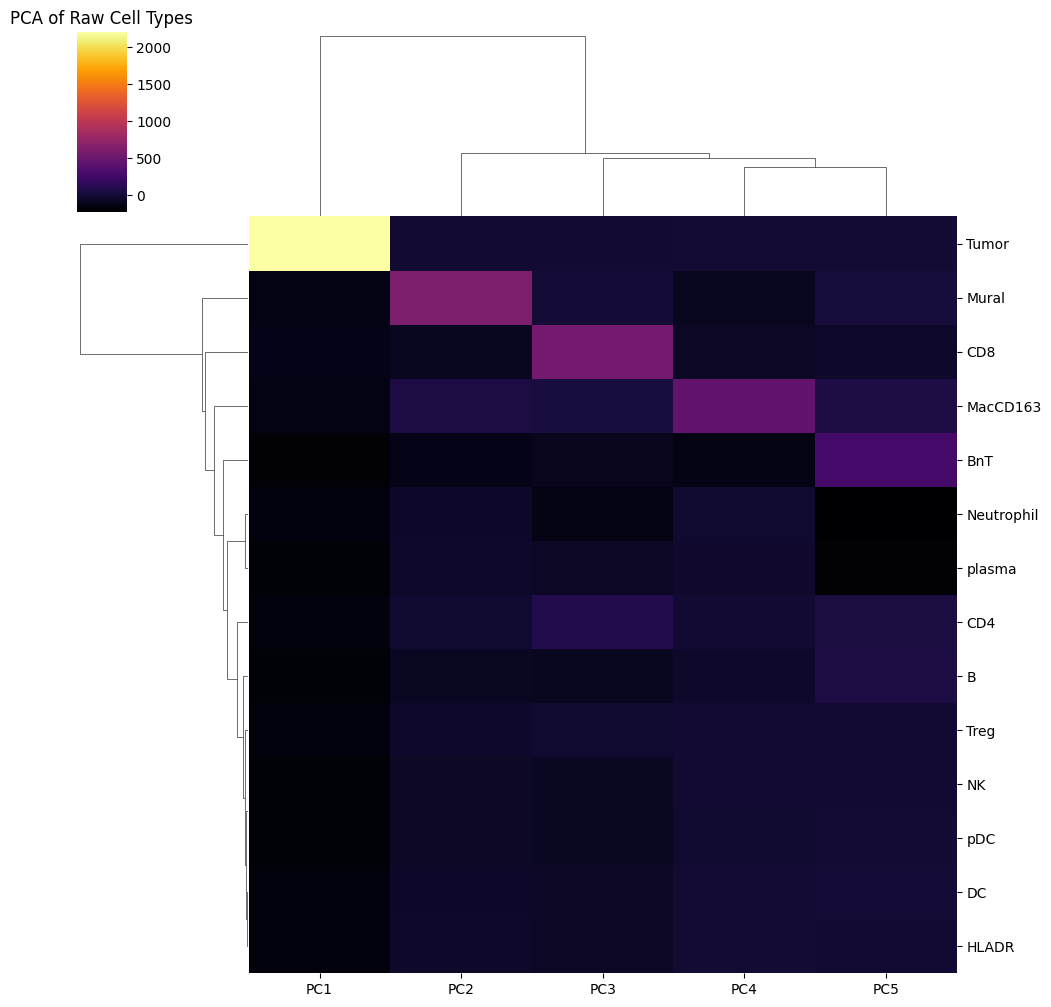

In [ ]:
raw_histograms = cell_type_histograms
celltypes_data = raw_histograms.T
unique_cell_types = train_anndata.obs['celltypes'].cat.categories.tolist()
celltypes_df = pd.DataFrame(celltypes_data, index=unique_cell_types)
pca_celltypes, pca_celltypes_model = run_pca(celltypes_df)

# PCA results to DataFrame
pca_columns = ['PC'+str(i+1) for i in range(pca_celltypes.shape[1])]
pca_celltypes_df = pd.DataFrame(pca_celltypes, index=unique_cell_types, columns=pca_columns)

# Plot clustermap
plot_clustermap(pca_celltypes_df, 'PCA of Raw Cell Types')

Now - let's perform a clustering of each representation. For this we will use [`Cellcharter`](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) function [`ClusterAutoK`](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) that determines the number of clusters. Your task consists of the following steps:

- read the [documentation](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) of the method,
- enrich the `train_anndata.obsm` with both mean marker and cell type histogram representations,
- using example from the documentation, setup appropriate cluster selectors with a `gpu` backend for both of the modalities. Cluster selection shoud try number of clusters from range 10 to 30,
- run the cluster selection on the representations. In order to speed up computations you can downsample the table by a factor of 10 or 20,
- plot the cluster selection results using a provided `cellcharter` [function](https://cellcharter.readthedocs.io/en/latest/generated/cellcharter.pl.autok_stability.html) and analyze the results,
- for both modalities, select number of clusters and compute appropriate predictions. Store them in the `train_anndata`. Which field of the `anndata` suits this data the most?
- for both modalities, compute the average cell type abundance and average marker expressions for each cluster.

In [ ]:
downsample_factor = 20
n_cells = train_anndata.n_obs
downsample_indices = np.arange(0, n_cells, downsample_factor)

mean_marker_ds = train_anndata.obsm['mean_marker'][downsample_indices]
cell_hist_ds = train_anndata.obsm['cell_type_hist'][downsample_indices]
train_anndata.obsm['mean_marker'][downsample_indices] = mean_marker_ds
train_anndata.obsm['cell_type_hist'][downsample_indices] = cell_hist_ds
train_anndata.obsm['mean_marker'] = train_anndata.obsm['mean_marker'].astype('float32')
train_anndata.obsm['cell_type_hist'] = train_anndata.obsm['cell_type_hist'].astype('float32')

# Range of clusters to test
n_clusters_range = list(range(10, 31))

# ClusterAutoK
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu',
        },
}
cluster_selector_marker = cellcharter.tl.ClusterAutoK(
    n_clusters=n_clusters_range,
    model_params=model_params
)
cluster_selector_hist = cellcharter.tl.ClusterAutoK(
    n_clusters=n_clusters_range,
    model_params=model_params
)

# Run cluster selection on the data
print("Running cluster selection for mean marker expression representation ...")
cluster_selector_marker.fit(train_anndata, use_rep='mean_marker')

print("Running cluster selection for cell type histogram representation ...")
cluster_selector_hist.fit(train_anndata, use_rep='cell_type_hist')

# Plot cluster selection results
cellcharter.tl.plot_cluster_selection_results(cluster_selector_marker,
                                              title="Cluster Selection on Mean Marker Expression"
)
plt.show()

cellcharter.tl.plot_cluster_selection_results(cluster_selector_hist,
                                              title="Cluster Selection on Cell Type Histograms"
)
plt.show()

Running cluster selection for mean marker expression representation ...
Iteration 1/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 6/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 7/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 8/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 9/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Convergence with a change in stability of 0.008955480000088358 reached after 9 iterations
Running cluster selection for cell type histogram representation ...
Iteration 1/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 6/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 7/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 8/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 9/10


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Convergence with a change in stability of 0.006630912871852985 reached after 9 iterations


AttributeError: module 'cellcharter.tl' has no attribute 'plot_cluster_selection_results'